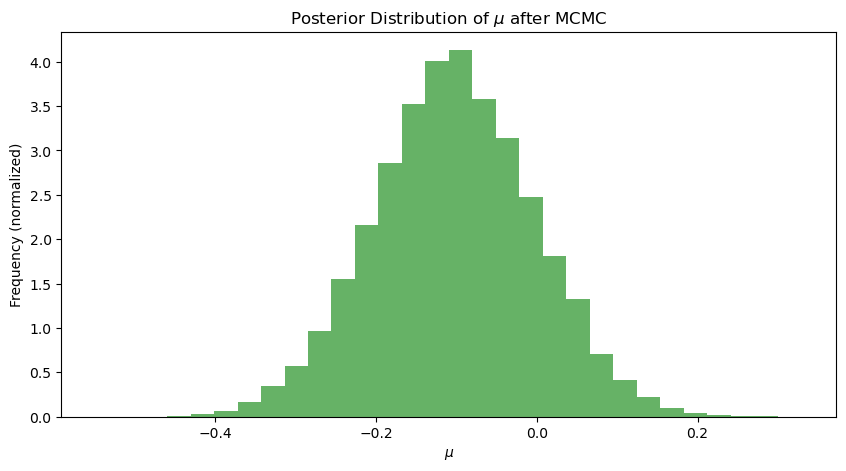

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Metropolis-Hastings algorithm
def metropolis_hastings(data, prior_mu, prior_var, proposal_width, iterations):
    mu_current = prior_mu
    posterior_samples = []
    
    for i in range(iterations):
        # Propose a new candidate from a symmetric proposal distribution
        mu_proposal = np.random.normal(mu_current, proposal_width)
        
        # Calculate the likelihood by assuming a Gaussian model
        likelihood_current = np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_squared)) -  0.5 * ((data - mu_current) ** 2) / sigma_squared)
        likelihood_proposal = np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_squared)) -  0.5 * ((data - mu_proposal) ** 2) / sigma_squared)
        
        # Calculate prior probability of current and proposed mu        
        prior_current = np.log(1 / np.sqrt(2 * np.pi * prior_var)) -  0.5 * ((mu_current - prior_mu) ** 2) / prior_var
        prior_proposal = np.log(1 / np.sqrt(2 * np.pi * prior_var)) -  0.5 * ((mu_proposal - prior_mu) ** 2) / prior_var
        
        # Calculate the acceptance probability
        p_accept = np.exp(likelihood_proposal + prior_proposal -  likelihood_current - prior_current)
        
        # Accept proposal with the acceptance probability
        if np.random.rand() < p_accept:
            mu_current = mu_proposal
        
        posterior_samples.append(mu_current)
    
    return posterior_samples

# Generating synthetic data
np.random.seed(42)
true_mu = 0
sigma_squared = 1
N = 100
observations = np.random.normal(true_mu, np.sqrt(sigma_squared), N)

# Prior parameters
mu_0 = 0  # Prior mean
tau_squared = 1  # Prior variance



# Running the Metropolis-Hastings algorithm
iterations = 100_000
proposal_width = 0.5
posterior_samples = metropolis_hastings(observations, mu_0, tau_squared, proposal_width, iterations)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.hist(posterior_samples, bins=30, density=True, alpha=0.6, color='g')
plt.title('Posterior Distribution of $\mu$ after MCMC')
plt.xlabel('$\mu$')
plt.ylabel('Frequency (normalized)')
plt.show()


In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

np.random.seed(42)

# Generating synthetic data
true_mu = 0
sigma_squared = 1
N = 100
observations = np.random.normal(true_mu, np.sqrt(sigma_squared), N)

# Prior parameters
mu_0 = 0  # Prior mean
tau_squared = 1  # Prior variance

# Initial variational parameters
mu_var_init = 0.0
log_sigma_var_init = 0.0  # Using log(sigma^2_var) for numerical stability

# Objective function to minimize (negative ELBO)
def neg_elbo(params, data, prior_mu, prior_var, sigma_squared):
    mu_var, log_sigma_var = params
    sigma_var = np.exp(log_sigma_var)
    
    # Expected log likelihood term
    expected_log_likelihood = np.sum(norm.logpdf(data, loc=mu_var, scale=np.sqrt(sigma_squared)))
    
    # KL divergence between variational distribution and prior
    kl_divergence = 0.5 * (np.log(prior_var) - log_sigma_var + (sigma_var + (mu_var - prior_mu)**2) / prior_var - 1)
    
    # Negative ELBO (since we are minimizing)
    return -(expected_log_likelihood - kl_divergence)

# Minimize the negative ELBO
result = minimize(neg_elbo, [mu_var_init, log_sigma_var_init], args=(observations, mu_0, tau_squared, sigma_squared))

mu_var_opt, log_sigma_var_opt = result.x
sigma_var_opt = np.exp(log_sigma_var_opt)

print(f"Optimized mu_var: {mu_var_opt}")
print(f"Optimized sigma^2_var: {sigma_var_opt}")


Optimized mu_var: -0.10281832870488476
Optimized sigma^2_var: 1.0


/var/folders/vt/g8zbc68n2nj8dkk85n8b19440000gn/T/ipykernel_12146/3785194235.py:23: RuntimeWarning: divide by zero encountered in log
  posterior_new = np.sum((alpha + data - 1) * np.log(p_new))


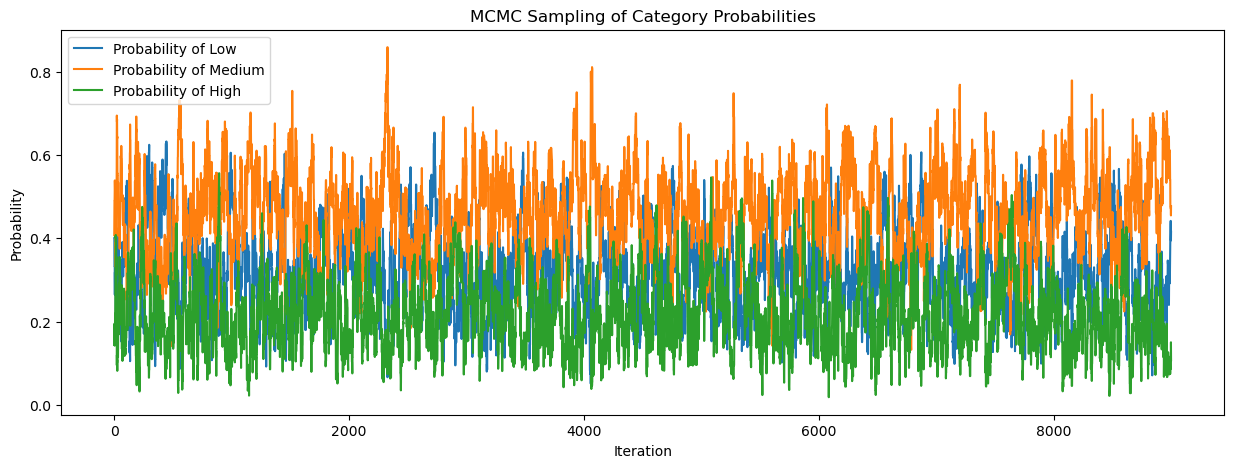

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility

# Observed data
data = np.array([5, 8, 3])  # Counts for low, medium, high

# Dirichlet prior parameters (alpha values)
alpha = np.array([1, 1, 1])  # Assuming a uniform prior for simplicity

# Proposal function
def propose(p):
    perturb = np.random.normal(0, 0.05, 3)  # Small random perturbations
    p_new = p + perturb
    p_new = np.maximum(p_new, 0)  # Ensure non-negative
    return p_new / p_new.sum()  # Normalize to ensure it sums to 1

# Acceptance probability function
def acceptance_prob(p_new, p_current, data, alpha):
    # Since we're not using a symmetric proposal, the acceptance probability simplifies to the posterior ratio
    posterior_current = np.sum((alpha + data - 1) * np.log(p_current))
    posterior_new = np.sum((alpha + data - 1) * np.log(p_new))
    return np.exp(posterior_new - posterior_current)

# Metropolis-Hastings sampler
def metropolis_hastings(data, alpha, iterations):
    p_current = np.array([1/3, 1/3, 1/3])  # Initial guess (uniform distribution)
    samples = [p_current]
    
    for _ in range(iterations):
        p_new = propose(p_current)
        accept_prob = acceptance_prob(p_new, p_current, data, alpha)
        
        if np.random.rand() < accept_prob:
            p_current = p_new
            
        samples.append(p_current)
        
    return np.array(samples)

# Running the sampler
iterations = 10000
samples = metropolis_hastings(data, alpha, iterations)

# Plotting the results
plt.figure(figsize=(15, 5))
for i, label in enumerate(['Low', 'Medium', 'High']):
    plt.plot(samples[1000:, i], label=f'Probability of {label}')

plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.title('MCMC Sampling of Category Probabilities')
plt.legend()
plt.show()


In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import digamma, gammaln

# Observed data: counts for low, medium, high
data = np.array([5, 8, 3])

# Prior parameters for the Dirichlet distribution
alpha = np.array([1, 1, 1])  # Uniform prior for simplicity

# Objective function: Negative Evidence Lower Bound (ELBO)
def neg_elbo(lambda_params, data, alpha):
    lambda_sum = np.sum(lambda_params)
    alpha_sum = np.sum(alpha)
    elbo = gammaln(lambda_sum) - np.sum(gammaln(lambda_params)) \
           + np.sum((lambda_params - 1) * (digamma(lambda_params) - digamma(lambda_sum))) \
           - (gammaln(alpha_sum) - np.sum(gammaln(alpha)) \
           + np.sum((alpha - 1) * (digamma(lambda_params) - digamma(lambda_sum)))) \
           + np.sum((lambda_params - alpha - data) * (digamma(lambda_params) - digamma(lambda_sum)))
    return -elbo

# Initial guess for the variational parameters
lambda_init = np.array([1.0, 1.0, 1.0])

# Minimize the negative ELBO
result = minimize(neg_elbo, lambda_init, args=(data, alpha), method='L-BFGS-B', bounds=[(0.001, None)]*3)

optimized_lambda = result.x

print(f"Optimized lambda parameters: {optimized_lambda}")


Optimized lambda parameters: [1.00000000e-03 1.00000000e-03 9.83681488e+04]


In [8]:
import numpy as np
from scipy.optimize import minimize

def dirichlet_log_pdf(alpha, x):
    return np.sum((alpha - 1.0) * np.log(x))

def multinomial_log_pdf(p, x):
    n = np.sum(x)
    coeff = np.log(np.math.factorial(n)) - np.sum(np.log(np.math.factorial(x)))
    return coeff + np.sum(x * np.log(p))

def objective(params, data, alpha_prior):
    alpha = np.exp(params)  # Ensure alpha is positive
    p = alpha / np.sum(alpha)
    return -(dirichlet_log_pdf(alpha_prior, p) + multinomial_log_pdf(p, data))

def vi_categorical(data, alpha_prior, tol=1e-6, maxiter=1000):
    params_init = np.log(np.random.dirichlet(alpha_prior))
    result = minimize(objective, params_init, args=(data, alpha_prior), method='L-BFGS-B', tol=tol, options={'maxiter': maxiter})
    alpha_post = np.exp(result.x)
    return alpha_post / np.sum(alpha_post)

# Example data and prior
data = np.array([5, 8, 3])
alpha_prior = np.array([1, 1, 1])

# Run VI
p_estimated = vi_categorical(data, alpha_prior)
print("Estimated probabilities:", p_estimated)


/var/folders/vt/g8zbc68n2nj8dkk85n8b19440000gn/T/ipykernel_12146/2689542927.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coeff = np.log(np.math.factorial(n)) - np.sum(np.log(np.math.factorial(x)))


TypeError: only integer scalar arrays can be converted to a scalar index

In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

def dirichlet_multinomial_log_pdf(alpha, x):
    """
    Compute the log PDF of the Dirichlet-Multinomial distribution.
    """
    n = np.sum(x)
    coeff = gammaln(n + 1) - np.sum(gammaln(x + 1))
    return coeff + gammaln(np.sum(alpha)) - gammaln(n + np.sum(alpha)) + np.sum(gammaln(x + alpha)) - np.sum(gammaln(alpha))

def objective(alpha, x):
    """
    Negative log posterior (to be minimized) for the Dirichlet parameters given data x.
    Assuming a flat prior for simplicity.
    """
    return -dirichlet_multinomial_log_pdf(alpha, x)

def vi_categorical(data):
    """
    Variational Inference for a categorical variable with a Dirichlet prior.
    """
    # Initial guess for alpha
    alpha_init = np.random.rand(3) + 1.0  # To avoid starting at zero

    # Data
    x = data

    # Optimize
    result = minimize(objective, alpha_init, args=(x,), method='L-BFGS-B', bounds=[(0.0001, None)]*3)

    if result.success:
        alpha_opt = result.x
    else:
        raise ValueError("Optimization did not converge.")

    return alpha_opt

# Observed data: low=5, medium=8, high=3
data = np.array([5, 8, 3])

# Run VI
alpha_opt = vi_categorical(data)
print(f"Optimized alpha: {alpha_opt}")


Optimized alpha: [281.11196206 454.19797194 170.35416802]
